In [21]:
%matplotlib inline
from multisim.multisim import *
import matplotlib.pyplot as plt
from scipy.linalg import expm, inv

from multisim.mpc import mpc

In [22]:
# set up system
nsteps = 500

tfaulton  = 0.5
tfaultoff = 0.6
tend      = 3.0

time   = np.linspace(0,tend,nsteps)
step   = time[1]

time_1 = [t for t in time if t < tfaulton]
time_2 = [t for t in time if t > tfaulton and t < tfaultoff]
time_3 = [t for t in time if t > tfaultoff]


# create system: this can be a file that we parse
dsystem = System()
dsystem.silent()

for i in range(9):
    dsystem.addbus(i)

dsystem.buses[0].setvinit(cmath.rect(1.04000, (np.pi/180.0)*0.0))
dsystem.buses[1].setvinit(cmath.rect(1.02500, (np.pi/180.0)*9.6926))
dsystem.buses[2].setvinit(cmath.rect(1.02500, (np.pi/180.0)*4.8812))
dsystem.buses[3].setvinit(cmath.rect(0.99574, (np.pi/180.0)*-2.3060))
dsystem.buses[4].setvinit(cmath.rect(0.95068, (np.pi/180.0)*-4.1382))
dsystem.buses[5].setvinit(cmath.rect(0.96621, (np.pi/180.0)*-3.7372))
dsystem.buses[6].setvinit(cmath.rect(0.99740, (np.pi/180.0)*3.9736))
dsystem.buses[7].setvinit(cmath.rect(0.97915, (np.pi/180.0)*0.8364))
dsystem.buses[8].setvinit(cmath.rect(1.00414, (np.pi/180.0)*2.1073))

dsystem.addbranch(0, 3, 0.0000, 0.0576)
dsystem.addbranch(1, 6, 0.0000, 0.0625)
dsystem.addbranch(2, 8, 0.0000, 0.0586)
dsystem.addbranch(3, 4, 0.0100, 0.0850)
dsystem.addbranch(3, 5, 0.0170, 0.0920)
dsystem.addbranch(4, 6, 0.0320, 0.1610)
dsystem.addbranch(5, 8, 0.0390, 0.1700)
dsystem.addbranch(6, 7, 0.0085, 0.0720)
dsystem.addbranch(7, 8, 0.0119, 0.1008)

dsystem.createYbusReal()

#gen1 = GenGENROU(0, 1.575, 1.512, 0.29, 0.39, 0.1733, 0.0787, 3.38, 0.0, 6.09, 1.0, 0.05, 0.15)
gen1 = GenCLS(0, 5.0, 1.0)

gen1.setinitpow(0.7234, 0.81363)

#gen2 = GenGENROU(1, 1.575, 1.512, 0.29, 0.39, 0.1733, 0.0787, 3.38, 0.0, 6.09, 1.0, 0.05, 0.15)
gen2 = GenCLS(1, 5.0, 1.0)

gen2.setinitpow(1.63, 0.53409)

#gen3 = GenGENROU(2, 1.575, 1.512, 0.29, 0.39, 0.1733, 0.0787, 3.38, 0.0, 6.09, 1.0, 0.05, 0.15)
gen3 = GenCLS(2, 5.0, 1.0)

gen3.setinitpow(0.85, 0.38552)

load1 = ZLoad(4, (138.3061 + 1j*-55.3224)/100.0)
load2 = ZLoad(5, (96.4050 + 1j*-32.1350)/100.0)
load3 = ZLoad(7, (104.3041 + 1j*-36.5065)/100.0)


dsystem.adddevice(gen1)
dsystem.adddevice(gen2)
dsystem.adddevice(gen3)


dsystem.addload(load1)
dsystem.addload(load2)
dsystem.addload(load3)

In [23]:
def discrete_system(x, dt):
    JX = np.zeros((2, 2))
    JU = np.zeros((2, 1))
    
    delta = x[0]
    w     = x[1]
    vr    = x[6]
    vi    = x[7]

    vt = np.abs(vr + 1j*vi)
    theta = cmath.phase(vr + 1j*vi)
    
    xd = 1.0
    eq = 1.80158210262
    
    JX[0, 1] = 2*np.pi*60
    JX[1, 0] = -vt*eq*np.cos(delta - theta)
    
    JU[1] = 1
    
    #Am = np.eye(JX.shape[0]) + dt*JX
    #Bm = dt*JU
    A = expm(dt*JX)
    B = np.dot(inv(JX), A - np.eye(2))
    B = np.dot(B, JU)
    
    return A, B

In [24]:
def generator_control(A, B, xdelta):
    
    n = 2 # state dimension
    m = 1  # input dimension

    T = 100
    kappa  = 0.01
    niter = 5
    quiet  = 1.0

    A = np.asfortranarray(A)
    B = np.asfortranarray(B)

    Q = np.asfortranarray(np.eye(n))
    Q[1, 1] = 10.0
    R = np.asfortranarray(np.eye(m))       

    xmin = -900*np.ones(n)
    xmax =  900*np.ones(n)
    umin = -0.1*np.ones(m)
    umax = 0.1*np.ones(m)

    Qf     = Q

    X = np.zeros((n,T), order = 'F')
    U = np.zeros((m,T), order = 'F')

    X0 = np.zeros((n,T), order = 'F')
    U0 = np.zeros((m,T), order = 'F')

    x = np.array([xdelta[0], xdelta[1]], dtype = np.float64)
    mpc.mpc_step(A, B, Q, R, xmax, xmin, umax, umin, n, m, T, Qf, kappa, niter, quiet, X0, U0, x, X, U, 0.1)
    
    return U[:, 0]

In [25]:
# Solve system
x = initialize_system(dsystem)

# allocate array for trajectory plus steady-state solutions
trajectory = np.zeros((len(x), len(time) + 2))
trajectory[:,0] = np.copy(x)

# prepare variable to index array
k = 0

# integrate to t_on
for i in range(len(time_1)):
    trajectory[:, i + 1] = propagate_system(trajectory[:, i], dsystem, step)
    
    if (0):
        xdelta = trajectory[:, k + 1] - trajectory[:, k - 10]
        A, B   = discrete_system(trajectory[:, k + 1], step)
        u      = generator_control(A, B, xdelta)
        dsystem.devices[0].p_m += u
    
    k = k + 1
    
# apply fault
fault_id = dsystem.applyBusFault(0, 0.1)
x = solve_steady_system(trajectory[:, k - 1], dsystem)
trajectory[:, k] = np.copy(x)

# integrate to t_off
for i in range(len(time_2)):
    trajectory[:, k + 1] = propagate_system(trajectory[:, k], dsystem, step)

    # control loop
    if (1):
        xdelta = trajectory[:, k + 1] - trajectory[:, k - 10]
        A, B   = discrete_system(trajectory[:, k + 1], step)
        u      = generator_control(A, B, xdelta)
        dsystem.devices[0].p_m += u
    
    k  = k + 1
    
    #print "At time: %g apply control: %g" % (time_2[i], u)


    
# remove fault
dsystem.removeBusFault(fault_id)
x = solve_steady_system(trajectory[:, k - 1], dsystem)
trajectory[:, k] = np.copy(x)

# integrate to t_end
for i in range(len(time_3)):
    trajectory[:, k + 1] = propagate_system(trajectory[:, k], dsystem, step)
    
    # control loop  
    if (1):
        xdelta = trajectory[:, k + 1] - trajectory[:, k - 10]
        A, B   = discrete_system(trajectory[:, k + 1], step)
        u      = generator_control(A, B, xdelta)
        dsystem.devices[0].p_m += u
    
    k  = k + 1

1.95057368877 0.7234
2.21792419873 1.63
1.62813235149 0.85
>>>APPLYING FAULT at bus: 0, z: 0.1.
Solve steady state
<<<REMOVING FAULT at bus: 0, z: 0.1.
Solve steady state


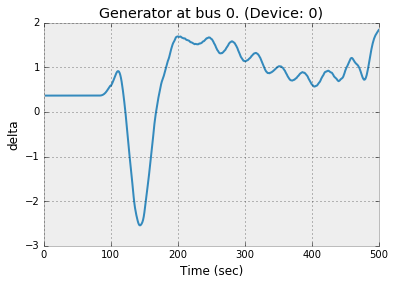

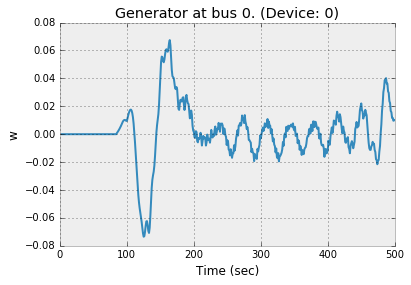

In [26]:
generator_plots(dsystem, trajectory[:,:-1], 0)